In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Just a formatting related plugin
%load_ext nb_black

<IPython.core.display.Javascript object>

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>

In [4]:
import torch
import numpy as np
from numba import cuda, jit, prange, vectorize, guvectorize
import tqdm
from joblib import Parallel, delayed

import sbi
from sbi import utils as utils
from sbi.inference.base import infer
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi

<IPython.core.display.Javascript object>

In [5]:
sbi.__version__

'0.14.2'

<IPython.core.display.Javascript object>

In [6]:
torch.device("cuda")

device(type='cuda')

<IPython.core.display.Javascript object>

In [9]:
torch.get_num_threads()

16

<IPython.core.display.Javascript object>

In [8]:
torch.set_num_threads(16)

<IPython.core.display.Javascript object>

In [10]:
import contextlib
import joblib
from tqdm import tqdm
from joblib import Parallel, delayed


@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    """Context manager to patch joblib to report into tqdm progress bar given as argument"""

    class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):
        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)

        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)

    old_batch_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback
    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_batch_callback
        tqdm_object.close()

<IPython.core.display.Javascript object>

# A basic model of review generation

This is a probabilistic model of a single customer's journey. Eventually, the simulation works by picking a random number of reviews that needs to generated and simulating new customers till that number of reviews has been achieved (or, a max number of simulated customers has been hit). This process makes it possible to generate review distributions with different total number of reviews irrespective of the value of $\rho$, the parameter that controls the energy barrier to reviewing.

**Note: = denotes equality, ~ denotes a single draw from a probability distribution**

**For a single customer**, they begin with a prior for the review distribution of a product and the currently existing review distribution for the same product. Both of these are Dirichlet-distributed as follows:

Review distribution prior for arriving customer (same for every customer and product):
$$
\text{Prior} = Dirichlet(\alpha_1,..,\alpha_5=1.0)
$$

Existing distribution for product:
$$
\text{Reviews} = Dirichlet(\beta_1,..,\beta_5), \beta_i=\text{Currently existing number of reviews with rating=i}
$$

Customer adds the review numbers of the prior and existing distribution to form a posterior of "quality":
$$
\text{Quality posterior} = \text{Prior}+\text{Reviews} = Dirichlet(\alpha_1+\beta_1,..,\alpha_5+\beta_5)
$$

Customer now pulls a single multinomial draw from the quality posterior - this is their "utility" distribution which combines quality and "fit":
$$
\text{Utility} = Multinomial(\sum_{i=1}^{i=5}p_i=1) \sim \text{Quality posterior}  
$$

Customer buys the product if the utility mean is higher than the prior mean (customer expects to have a better "experience" than the prior would suggest). Customer also buys product if no reviews exist for the product yet (to deal with the cold start problem):
$$
\text{Expected experience} = \sum_{i=1}^{i=5}(i \times p_i) - \frac{\sum_{i=1}^{i=5}(i \times \alpha_i)}{\sum_{i=1}^{i=5} \alpha_i}
$$

If customer buys the product, they draw an actual "experience" from their multinomial utility distribution. The actual experience is an integer from 1 to 5:
$$
\text{Experience} \sim Utility \in [1, 5]
$$

Now customer calculates the difference between their "actual" experience and their "expected" experience:
$$
\Delta = \text{Experience} - \sum_{i=1}^{i=5}(i \times p_i)
$$

Customer uses this difference to decide on the rating they will give to the product:
$$
\text{Rating} = 
\begin{cases}
    1,& \text{if } \Delta \in (-\infty, -1.5] \\
    2,& \text{if } \Delta \in (-1.5, -0.5] \\
    3,& \text{if } \Delta \in (-0.5, 0.5] \\
    4,& \text{if } \Delta \in (0.5, 1.5] \\
    5,& \text{if } \Delta \in (1.5, \infty) 
\end{cases}
$$

**Now, customer leaves a rating by comparing $\Delta$ to the energy barrier to rate, $\rho$.**

If we have the same $\rho$ for both positive and negative $\Delta$, the customer leaves their rating in any of the following situations:
1. A small, baseline probability of leaving the rating through *tendency to rate*
2. If $|\Delta| \geq \rho$

If we have different $\rho$ for positive and negative $\Delta$, the customer leaves their rating in any of the following situations:
1. A small, baseline probability of leaving the rating through *tendency to rate*
2. If $\Delta \geq 0$ and $|\Delta| \geq \rho_+$
3. If $\Delta < 0$ and $|\Delta| \geq \rho_-$

In any of the situations above moderated by $\Delta$ and $\rho$, the customer only leaves the review 60% of the time if the rating is <=3, but always if the rating > 3 (given positivity bias shown in review lit)

In [5]:
prior = utils.BoxUniform(low=torch.tensor([0.0]), high=torch.tensor([4.0]))

<IPython.core.display.Javascript object>

In [6]:
# rev_prior = torch.tensor([2.0, 2.0, 10.0, 3.0, 3.0])
# Keeping a flat prior for the reviews expected by the user
rev_prior = torch.tensor([1.0, 1.0, 1.0, 1.0, 1.0])

<IPython.core.display.Javascript object>

In [7]:
# This is how you would take the mean of a review distribution
a = rev_prior * torch.arange(1, 6)
a.sum() / rev_prior.sum()

tensor(3.)

<IPython.core.display.Javascript object>

In [11]:
tendency_to_rate = 0.05

<IPython.core.display.Javascript object>

In [12]:
# The function that simulates 1 visitor's journey (which may or may not end in review generation)


def visitor_journey(sim_revs, rho):
    # print("==========A New Visitor===========")
    # Convolve the current simulated review distribution with the prior to get the posterior of reviews
    post_revs_conc_params = sim_revs + rev_prior
    # print("Posterior:", post_revs_conc_params)

    # Add some reviews to one of the bins to add noise to this posterior
    # This "noisy" posterior is the utility distribution
    # add_revs_num = np.random.randint(low=5, high=50)
    # add_revs_bin = np.random.randint(low=0, high=4)
    # utility_conc_params = post_revs_conc_params.clone().detach()
    # utility_conc_params[add_revs_bin] += add_revs_num

    # Just make a single draw from the posterior Dirichlet dist of reviews to get the utility distribution
    utility_dist = torch.distributions.Dirichlet(post_revs_conc_params).sample()
    # print("Utility dist:", utility_dist)

    # Customer buys if mean of the utility distribution is >= prior mean
    # Also, first customer always buys and reviews
    # Reviews if experience is different from expectation
    prior_mean = torch.sum(rev_prior * torch.arange(1, 6)) / rev_prior.sum()
    # utility_mean = (
    #    torch.sum(utility_conc_params * torch.arange(1, 6)) / utility_conc_params.sum()
    # )
    utility_mean = torch.sum(utility_dist * torch.arange(1, 6))
    # print("Utility mean:", utility_mean)

    # If there are no existing reviews, the customer always buys
    if utility_mean >= prior_mean or torch.sum(sim_revs) == 0:
        # print("Bought")
        # Draw an experience from the user's utility distribution
        # experience_dist = torch.distributions.Dirichlet(utility_conc_params).sample()
        # experience = torch.multinomial(experience_dist, 1) + 1.0
        experience = torch.multinomial(utility_dist, 1) + 1.0
        # print("Experience:", experience)
        # Compare the mismatch in experience to rho
        delta = experience - utility_mean
        # print("Delta:", delta)
        if delta <= -1.5:
            review = 0
        elif delta > -1.5 and delta <= -0.5:
            review = 1
        elif delta > -0.5 and delta <= 0.5:
            review = 2
        elif delta > 0.5 and delta <= 1.5:
            review = 3
        else:
            review = 4

        # print("Generated:", review)

        # Return the review only if mismatch is higher than rho
        # We also make it slightly more likely for a customer to leave a review if the rating is positive
        # than if it is negative
        if np.random.random() <= tendency_to_rate:
            return review
        elif torch.abs(delta) >= rho and review <= 2 and np.random.random() <= 0.6:
            return review
        elif bool(torch.abs(delta) >= rho) and review > 2:
            return review
        else:
            return None

<IPython.core.display.Javascript object>

In [13]:
# This runs the model by:
# Picking a number of reviews that needs to be generated
# and simulating visitors either till that number or a max number of visitors has been reached
def model(rho):
    # Total number of reviews we want in this simulation
    revs_num = np.random.randint(low=20, high=1000)
    # Absolute total number of visitors - if we hit this number but haven't gotten revs_num reviews
    # we will stop with whatever reviews we have at that point
    total_visitors = revs_num * 30
    # Simulated distribution of reviews
    sim_revs = torch.zeros(5)

    for visitor in range(total_visitors):
        index = visitor_journey(sim_revs, rho)
        if index is not None:
            sim_revs[index] += 1
        if torch.sum(sim_revs) >= revs_num:
            break
    return sim_revs


#    return (
#        sim_revs,
#        100 * torch.sum(sim_revs) / visitor,
#        visitor == total_visitors - 1,
#        torch.sum(sim_revs),
#        revs_num,
#        visitor,
#    )

<IPython.core.display.Javascript object>

In [14]:
model(torch.tensor([4.0]))

tensor([ 95.,  45., 112., 137., 136.])

<IPython.core.display.Javascript object>

In [19]:
model(torch.tensor([2.6]))

tensor([40.,  4., 22., 77., 12.])

<IPython.core.display.Javascript object>

In [30]:
model(torch.tensor([0.1]))

tensor([ 94.,  75., 153., 471., 115.])

<IPython.core.display.Javascript object>

In [20]:
posterior = infer(model, prior, method="SNPE", num_simulations=15000, num_workers=16)

/etc/anaconda3/envs/sbi/lib/python3.7/site-packages/sbi/neural_nets/flow.py:108: UserWarning: In one-dimensional output space, this flow is limited to Gaussians
  warn(f"In one-dimensional output space, this flow is limited to Gaussians")


Neural network successfully converged after 88 epochs.


<IPython.core.display.Javascript object>

In [21]:
# Pickle the posterior
import pickle

with open("sbi_posterior_single_rho.pkl", "wb") as f:
    pickle.dump(posterior, f)

<IPython.core.display.Javascript object>

**$\rho$ for J shaped review distribution**

In [22]:
posterior_samples = posterior.sample((10000,), x=torch.tensor([15, 20, 30, 100, 600]))

<IPython.core.display.Javascript object>

(array([  27.,  187.,  841., 2012., 2866., 2442., 1205.,  361.,   49.,
          10.]),
 array([0.9489323, 1.0126328, 1.0763334, 1.140034 , 1.2037345, 1.2674351,
        1.3311355, 1.3948361, 1.4585366, 1.5222372, 1.5859377],
       dtype=float32),
 <BarContainer object of 10 artists>)

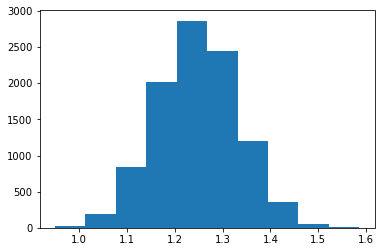

<IPython.core.display.Javascript object>

In [23]:
plt.hist(posterior_samples.numpy())

**$\rho$ for U shaped review distribution**

In [24]:
posterior_samples = posterior.sample((10000,), x=torch.tensor([180, 20, 30, 50, 600]))

<IPython.core.display.Javascript object>

(array([1.000e+00, 1.200e+01, 1.750e+02, 8.690e+02, 2.270e+03, 3.290e+03,
        2.351e+03, 8.490e+02, 1.610e+02, 2.200e+01]),
 array([0.71585226, 0.79252446, 0.86919665, 0.94586885, 1.022541  ,
        1.0992132 , 1.1758854 , 1.2525576 , 1.3292298 , 1.405902  ,
        1.4825742 ], dtype=float32),
 <BarContainer object of 10 artists>)

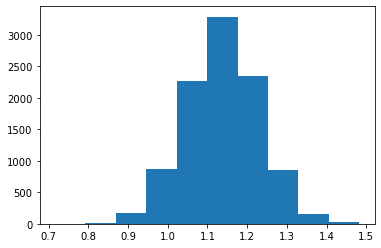

<IPython.core.display.Javascript object>

In [25]:
plt.hist(posterior_samples.numpy())

**$\rho$ for Gaussian review distribution**

In [26]:
posterior_samples = posterior.sample((10000,), x=torch.tensor([20, 50, 100, 50, 20]))

<IPython.core.display.Javascript object>

(array([  13.,   81.,  220.,  580., 1363., 1960., 2274., 1860., 1150.,
         499.]),
 array([1.8393608, 2.0553696, 2.2713783, 2.487387 , 2.7033958, 2.9194045,
        3.1354132, 3.3514218, 3.5674305, 3.7834394, 3.999448 ],
       dtype=float32),
 <BarContainer object of 10 artists>)

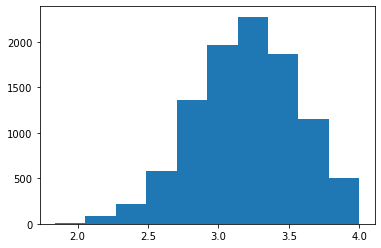

<IPython.core.display.Javascript object>

In [27]:
plt.hist(posterior_samples.numpy())

**$\rho$ for review distribution shifted towards +ive but not peaked at 3**

In [31]:
posterior_samples = posterior.sample((10000,), x=torch.tensor([20, 50, 100, 200, 40]))

<IPython.core.display.Javascript object>

(array([1209., 1822., 2098., 1928., 1525.,  829.,  383.,  145.,   54.,
           7.]),
 array([5.69376016e-06, 5.16338088e-02, 1.03261925e-01, 1.54890046e-01,
        2.06518158e-01, 2.58146286e-01, 3.09774399e-01, 3.61402512e-01,
        4.13030624e-01, 4.64658737e-01, 5.16286850e-01], dtype=float32),
 <BarContainer object of 10 artists>)

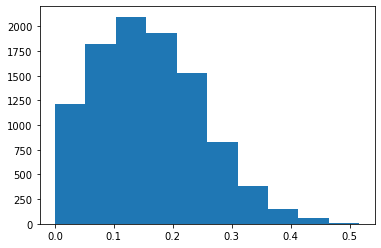

<IPython.core.display.Javascript object>

In [32]:
plt.hist(posterior_samples.numpy())

**$\rho$ for flat review distribution**

In [37]:
posterior_samples = posterior.sample((10000,), x=torch.tensor([10, 10, 10, 10, 10]))

<IPython.core.display.Javascript object>

(array([   4.,   21.,  115.,  307.,  814., 1475., 2108., 2202., 1857.,
        1097.]),
 array([0.8351703, 1.151647 , 1.4681237, 1.7846004, 2.101077 , 2.417554 ,
        2.7340305, 3.0505073, 3.366984 , 3.6834607, 3.9999373],
       dtype=float32),
 <BarContainer object of 10 artists>)

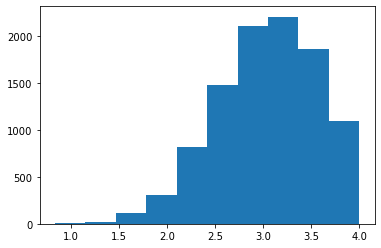

<IPython.core.display.Javascript object>

In [38]:
plt.hist(posterior_samples.numpy())

# Simulation with 2 different $\rho$, one for postive $\Delta$ and another for negative $\Delta$

In [19]:
num_dim = 2
prior = utils.BoxUniform(low=torch.zeros(num_dim), high=torch.ones(num_dim) * 4)

<IPython.core.display.Javascript object>

In [20]:
# rev_prior = torch.tensor([2.0, 2.0, 10.0, 3.0, 3.0])
# Keeping a flat prior for the reviews expected by the user
rev_prior = torch.tensor([1.0, 1.0, 1.0, 1.0, 1.0])

<IPython.core.display.Javascript object>

In [21]:
# This is how you would take the mean of a review distribution
a = rev_prior * torch.arange(1, 6)
a.sum() / rev_prior.sum()

tensor(3.)

<IPython.core.display.Javascript object>

In [22]:
tendency_to_rate = 0.05

<IPython.core.display.Javascript object>

In [23]:
# The function that simulates 1 visitor's journey (which may or may not end in review generation)


def visitor_journey(sim_revs, rho):
    # print("==========A New Visitor===========")
    # Convolve the current simulated review distribution with the prior to get the posterior of reviews
    post_revs_conc_params = sim_revs + rev_prior
    # print("Posterior:", post_revs_conc_params)

    # Add some reviews to one of the bins to add noise to this posterior
    # This "noisy" posterior is the utility distribution
    # add_revs_num = np.random.randint(low=5, high=50)
    # add_revs_bin = np.random.randint(low=0, high=4)
    # utility_conc_params = post_revs_conc_params.clone().detach()
    # utility_conc_params[add_revs_bin] += add_revs_num

    # Just make a single draw from the posterior Dirichlet dist of reviews to get the utility distribution
    utility_dist = torch.distributions.Dirichlet(post_revs_conc_params).sample()
    # print("Utility dist:", utility_dist)

    # Customer buys if mean of the utility distribution is >= prior mean
    # Also, first customer always buys and reviews
    # Reviews if experience is different from expectation
    prior_mean = torch.sum(rev_prior * torch.arange(1, 6)) / rev_prior.sum()
    # utility_mean = (
    #    torch.sum(utility_conc_params * torch.arange(1, 6)) / utility_conc_params.sum()
    # )
    utility_mean = torch.sum(utility_dist * torch.arange(1, 6))
    # print("Utility mean:", utility_mean)

    # If there are no existing reviews, the customer always buys
    if utility_mean >= prior_mean or torch.sum(sim_revs) == 0:
        # print("Bought")
        # Draw an experience from the user's utility distribution
        # experience_dist = torch.distributions.Dirichlet(utility_conc_params).sample()
        # experience = torch.multinomial(experience_dist, 1) + 1.0
        experience = torch.multinomial(utility_dist, 1) + 1.0
        # print("Experience:", experience)
        # Compare the mismatch in experience to rho
        delta = experience - utility_mean
        # print("Delta:", delta)
        if delta <= -1.5:
            review = 0
        elif delta > -1.5 and delta <= -0.5:
            review = 1
        elif delta > -0.5 and delta <= 0.5:
            review = 2
        elif delta > 0.5 and delta <= 1.5:
            review = 3
        else:
            review = 4

        # print("Generated:", review)

        # Return the review only if mismatch is higher than rho
        # We also make it slightly more likely for a customer to leave a review if the rating is positive
        # than if it is negative
        if np.random.random() <= tendency_to_rate:
            return review
        elif (
            delta < 0
            and torch.abs(delta) >= rho[0]
            and review <= 2
            and np.random.random() <= 0.6
        ):
            return review
        elif delta < 0 and torch.abs(delta) >= rho[0] and review > 2:
            return review
        elif (
            delta >= 0
            and torch.abs(delta) >= rho[1]
            and review <= 2
            and np.random.random() <= 0.6
        ):
            return review
        elif delta >= 0 and torch.abs(delta) >= rho[1] and review > 2:
            return review
        else:
            return None

<IPython.core.display.Javascript object>

In [24]:
# This runs the model by:
# Picking a number of reviews that needs to be generated
# and simulating visitors either till that number or a max number of visitors has been reached
def model(rho):
    # Total number of reviews we want in this simulation
    revs_num = np.random.randint(low=20, high=1000)
    # Absolute total number of visitors - if we hit this number but haven't gotten revs_num reviews
    # we will stop with whatever reviews we have at that point
    total_visitors = revs_num * 30
    # Simulated distribution of reviews
    sim_revs = torch.zeros(5)

    for visitor in range(total_visitors):
        index = visitor_journey(sim_revs, rho)
        if index is not None:
            sim_revs[index] += 1
        if torch.sum(sim_revs) >= revs_num:
            break
    return sim_revs


#    return (
#        sim_revs,
#        100 * torch.sum(sim_revs) / visitor,
#        visitor == total_visitors - 1,
#        torch.sum(sim_revs),
#        revs_num,
#        visitor,
#    )

<IPython.core.display.Javascript object>

In [25]:
model(torch.tensor([1.0, 0.5]))

tensor([ 53.,  13.,   5., 176.,  39.])

<IPython.core.display.Javascript object>

In [26]:
model(torch.tensor([2.6, 3.5]))

tensor([10.,  8., 16., 16.,  5.])

<IPython.core.display.Javascript object>

In [27]:
model(torch.tensor([0.1, 0.7]))

tensor([ 14.,  78.,  38., 150.,  28.])

<IPython.core.display.Javascript object>

In [28]:
posterior = infer(model, prior, method="SNPE", num_simulations=15000, num_workers=16)


Neural network successfully converged after 142 epochs.


<IPython.core.display.Javascript object>

In [29]:
# Pickle the posterior
import pickle

with open("sbi_posterior_double_rho.pkl", "wb") as f:
    pickle.dump(posterior, f)

<IPython.core.display.Javascript object>

**$\rho$ for J shaped review distribution**

In [30]:
posterior_samples = posterior.sample((10000,), x=torch.tensor([15, 20, 30, 100, 600]))

<IPython.core.display.Javascript object>

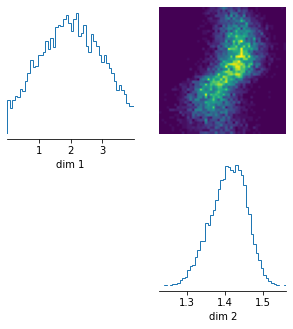

<IPython.core.display.Javascript object>

In [31]:
_ = utils.pairplot(posterior_samples, fig_size=(5,5))

**$\rho$ for U shaped review distribution**

In [32]:
posterior_samples = posterior.sample((10000,), x=torch.tensor([180, 20, 30, 50, 600]))

<IPython.core.display.Javascript object>

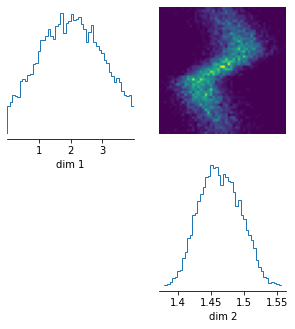

<IPython.core.display.Javascript object>

In [33]:
_ = utils.pairplot(posterior_samples, fig_size=(5, 5))

**$\rho$ for Gaussian review distribution**

In [34]:
posterior_samples = posterior.sample((10000,), x=torch.tensor([20, 50, 100, 50, 20]))

<IPython.core.display.Javascript object>

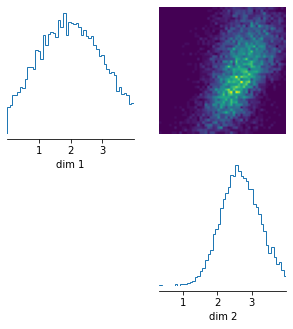

<IPython.core.display.Javascript object>

In [35]:
_ = utils.pairplot(posterior_samples, fig_size=(5, 5))

**$\rho$ for review distribution shifted towards +ive but not peaked at 3**

In [36]:
posterior_samples = posterior.sample((10000,), x=torch.tensor([20, 50, 100, 200, 40]))

<IPython.core.display.Javascript object>

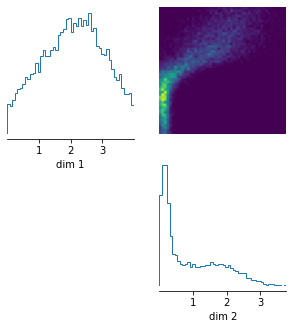

<IPython.core.display.Javascript object>

In [37]:
_ = utils.pairplot(posterior_samples, fig_size=(5,5))

# Using the trained network to infer the posterior on real products

In [38]:
import pickle

with open("sbi_posterior_double_rho.pkl", "rb") as f:
    posterior = pickle.load(f)

<IPython.core.display.Javascript object>

In [39]:
import pandas as pd

<IPython.core.display.Javascript object>

In [40]:
# Load up the data
ratings = pd.read_csv("rating_snpe/rating_hist_speakers_snpe.txt", sep="\t")
features = pd.read_csv("rating_snpe/prod_price_brand_snpe.txt", sep="\t")

<IPython.core.display.Javascript object>

In [41]:
ratings.tail()

,asin,1,2,3,4,5
954,B00JRTMOGS,82,27,17,20,76
955,B00JST4TLA,9,3,6,2,13
956,B00JST4VHW,60,58,48,117,385
957,B00JWV1M3W,9,6,2,8,18
958,B00L26YDA4,42,42,41,47,94


<IPython.core.display.Javascript object>

In [42]:
features.head()

,asin,val,productGroup,brand
0,B00000K2YR,77.860,Speakers,Midland
1,B00001P4XA,17.530,Speakers,Koss
2,B00001P4XH,9.010,Speakers,Koss
3,B00001P4ZH,39.355,Speakers,Koss
4,B00001P505,22.955,Speakers,Koss


<IPython.core.display.Javascript object>

In [43]:
len(ratings) == len(features)

True

<IPython.core.display.Javascript object>

In [44]:
features["mean_rho"] = np.nan
features["sd_rho"] = np.nan

<IPython.core.display.Javascript object>

In [51]:
# Now run through the products, get the posterior over rho for each of them, and save
# the mean and sd of that posterior in the right row in the features DF
for row in range(len(ratings)):
    obs_ratings = np.array(ratings.iloc[row, 1:], dtype=np.float64)
    posterior_samples = posterior.sample((10000,), x=torch.tensor(obs_ratings)).numpy()
    posterior_mean = np.mean(posterior_samples)
    posterior_sd = np.std(posterior_samples)
    feature_df_index = np.where(features["asin"] == ratings.iloc[row, 0])[0][0]
    features.iloc[feature_df_index, 4] = posterior_mean
    features.iloc[feature_df_index, 5] = posterior_sd

<IPython.core.display.Javascript object>

In [52]:
features.head()

,asin,val,productGroup,brand,mean_rho,sd_rho
0,B00000K2YR,77.860,Speakers,Midland,1.259208,0.168150
1,B00001P4XA,17.530,Speakers,Koss,1.167548,0.155284
2,B00001P4XH,9.010,Speakers,Koss,1.422566,0.160284
3,B00001P4ZH,39.355,Speakers,Koss,1.496117,0.151946
4,B00001P505,22.955,Speakers,Koss,1.252120,0.182817


<IPython.core.display.Javascript object>

<AxesSubplot:>

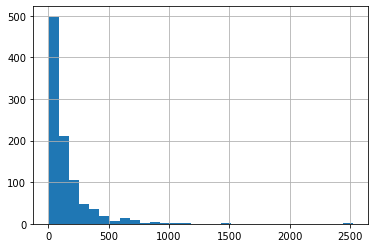

<IPython.core.display.Javascript object>

In [60]:
features.val.hist(bins=30)

In [61]:
# Remove the very high priced products
normal_features = features.loc[features["val"] <= 300, :]

<IPython.core.display.Javascript object>

<AxesSubplot:>

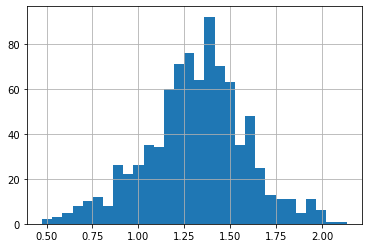

<IPython.core.display.Javascript object>

In [62]:
normal_features.mean_rho.hist(bins=30)

<AxesSubplot:>

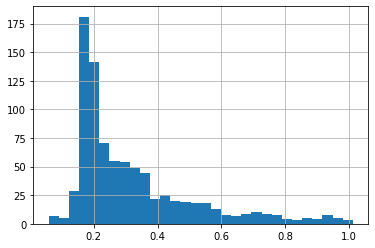

<IPython.core.display.Javascript object>

In [66]:
normal_features.sd_rho.hist(bins=30)

In [63]:
normal_features.mean_rho.corr(normal_features.val)

0.02861004383915438

<IPython.core.display.Javascript object>

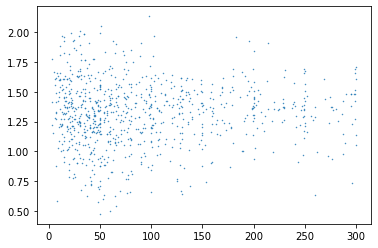

<IPython.core.display.Javascript object>

In [64]:
plt.scatter(normal_features.val, normal_features.mean_rho, s=0.2)

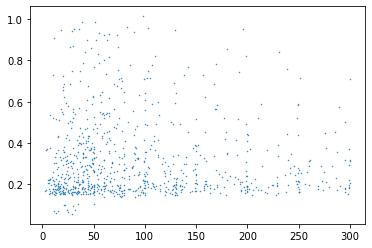

<IPython.core.display.Javascript object>

In [65]:
plt.scatter(normal_features.val, normal_features.sd_rho, s=0.2)

In [67]:
normal_features.sd_rho.corr(normal_features.val)

-0.029341040944801857

<IPython.core.display.Javascript object>

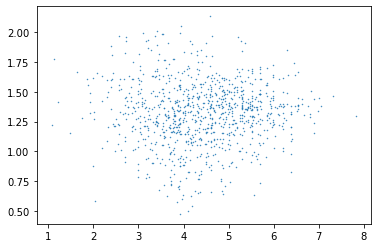

<IPython.core.display.Javascript object>

In [70]:
plt.scatter(np.log(features.val), features.mean_rho, s=0.2)

In [71]:
features.mean_rho.corr(np.log(features.val))

0.007132198021683755

<IPython.core.display.Javascript object>

# Tests

In [11]:
sim_revs = torch.zeros(5)

<IPython.core.display.Javascript object>

In [12]:
post_revs_conc_params = sim_revs + rev_prior
post_revs_conc_params

tensor([2., 2., 2., 2., 2.])

<IPython.core.display.Javascript object>

In [270]:
utility_dist = torch.distributions.Dirichlet(post_revs_conc_params).sample()
utility_dist

tensor([0.3523, 0.2338, 0.1141, 0.0728, 0.2270])

<IPython.core.display.Javascript object>

In [271]:
prior_mean = torch.sum(rev_prior * torch.arange(1, 6)) / rev_prior.sum()
prior_mean

tensor(3.)

<IPython.core.display.Javascript object>

In [272]:
utility_mean = torch.sum(utility_dist * torch.arange(1, 6))
utility_mean

tensor(2.5884)

<IPython.core.display.Javascript object>

In [273]:
experience = torch.multinomial(utility_dist, 1) + 1.0
experience

tensor([1.])

<IPython.core.display.Javascript object>

In [274]:
delta = experience - utility_mean
delta

tensor([-1.5884])

<IPython.core.display.Javascript object>

In [277]:
delta = experience - utility_mean
if delta <= -1.5:
    review = 0
elif delta >= -1.5 and delta <= -0.5:
    review = 1
elif delta >= -0.5 and delta <= 0.5:
    review = 2
elif delta >= 0.5 and delta <= 1.5:
    review = 3
else:
    review = 4

review

0

<IPython.core.display.Javascript object>

In [124]:
torch.abs(delta) < torch.tensor([4.0]) and (1 < 2)

True

<IPython.core.display.Javascript object>

In [276]:
torch.abs(delta) >= torch.tensor([2.0])

tensor([False])

<IPython.core.display.Javascript object>

In [38]:
sim_revs = torch.zeros(5)
for i in range(100):
    index = visitor_journey(sim_revs, torch.tensor([3.0]))
    print("Returned: ", index)
    if index is not None:
        sim_revs[index] += 1

==========A New Visitor===========
Posterior: tensor([2., 2., 2., 2., 2.])
Utility dist: tensor([0.1619, 0.4134, 0.0933, 0.2631, 0.0683])
Utility mean: tensor(2.6626)
Bought
Experience: tensor([1.])
Delta: tensor([-1.6626])
Generated: 0
Returned:  None
==========A New Visitor===========
Posterior: tensor([2., 2., 2., 2., 2.])
Utility dist: tensor([0.1097, 0.0771, 0.0357, 0.4189, 0.3585])
Utility mean: tensor(3.8393)
Bought
Experience: tensor([4.])
Delta: tensor([0.1607])
Generated: 2
Returned:  None
==========A New Visitor===========
Posterior: tensor([2., 2., 2., 2., 2.])
Utility dist: tensor([0.1491, 0.5478, 0.2130, 0.0655, 0.0245])
Utility mean: tensor(2.2685)
Bought
Experience: tensor([1.])
Delta: tensor([-1.2685])
Generated: 1
Returned:  None
==========A New Visitor===========
Posterior: tensor([2., 2., 2., 2., 2.])
Utility dist: tensor([0.1596, 0.1691, 0.0869, 0.1515, 0.4329])
Utility mean: tensor(3.5288)
Bought
Experience: tensor([1.])
Delta: tensor([-2.5288])
Generated: 0
Retur

Posterior: tensor([3., 2., 2., 2., 2.])
Utility dist: tensor([0.4445, 0.2680, 0.1070, 0.0493, 0.1312])
Utility mean: tensor(2.1547)
Returned:  None
==========A New Visitor===========
Posterior: tensor([3., 2., 2., 2., 2.])
Utility dist: tensor([0.1850, 0.3350, 0.2608, 0.1109, 0.1084])
Utility mean: tensor(2.6226)
Returned:  None
==========A New Visitor===========
Posterior: tensor([3., 2., 2., 2., 2.])
Utility dist: tensor([0.1974, 0.3889, 0.2399, 0.0589, 0.1149])
Utility mean: tensor(2.5051)
Returned:  None
==========A New Visitor===========
Posterior: tensor([3., 2., 2., 2., 2.])
Utility dist: tensor([0.2498, 0.3464, 0.1052, 0.0909, 0.2077])
Utility mean: tensor(2.6602)
Returned:  None
==========A New Visitor===========
Posterior: tensor([3., 2., 2., 2., 2.])
Utility dist: tensor([0.1992, 0.1123, 0.1089, 0.4094, 0.1703])
Utility mean: tensor(3.2393)
Bought
Experience: tensor([5.])
Delta: tensor([1.7607])
Generated: 4
Returned:  None
==========A New Visitor===========
Posterior: tenso

<IPython.core.display.Javascript object>

In [18]:
data = model(torch.tensor([2.0]))

<IPython.core.display.Javascript object>

In [19]:
data

tensor([22.,  2.,  3.,  2.,  6.])

<IPython.core.display.Javascript object>

In [24]:
posterior_samples = posterior.sample((10000,), x=data * 10)

<IPython.core.display.Javascript object>

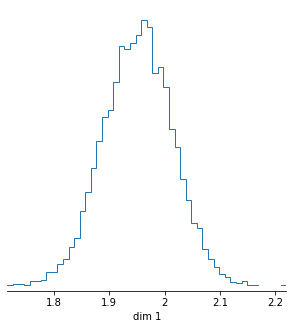

<IPython.core.display.Javascript object>

In [25]:
_ = utils.pairplot(posterior_samples, fig_size=(5, 5))

In [26]:
data * 100

tensor([2200.,  200.,  300.,  200.,  600.])

<IPython.core.display.Javascript object>

# New model written in Numpy (which for some reason is faster than the Pytorch version)

In [11]:
# num_dim = 2
prior = utils.BoxUniform(
    low=torch.tensor([0.0, 0.0]).type(torch.FloatTensor),
    high=torch.tensor([4.0, 4.0]).type(torch.FloatTensor),
)

<IPython.core.display.Javascript object>

In [28]:
# The function that simulates 1 visitor's journey (which may or may not end in review generation)
# @jit(forceobj=True, looplift=True)
def visitor_journey(rev_prior, sim_revs, rho):
    # print("==========A New Visitor===========")
    # Convolve the current simulated review distribution with the prior to get the posterior of reviews
    post_revs_conc_params = sim_revs + rev_prior
    # print("Posterior:", post_revs_conc_params)

    # Just make a single draw from the posterior Dirichlet dist of reviews to get the utility distribution
    expected_dist = np.random.dirichlet(post_revs_conc_params)
    # print("Utility dist:", utility_dist)

    expected_dist_mean = np.sum(expected_dist * np.arange(1, 6))
    # print("Utility mean:", utility_mean)

    # Draw an experience from the user's expected distribution
    # experience_dist = torch.distributions.Dirichlet(utility_conc_params).sample()
    experience = np.where(np.random.multinomial(1, expected_dist))[0][0] + 1.0
    # print("Experience:", experience)
    # Compare the mismatch in experience to rho
    delta = experience - expected_dist_mean
    # print("Delta:", delta)
    if delta <= -1.5:
        review = 0
    elif delta > -1.5 and delta <= -0.5:
        review = 1
    elif delta > -0.5 and delta <= 0.5:
        review = 2
    elif delta > 0.5 and delta <= 1.5:
        review = 3
    else:
        review = 4

    # print("Generated:", review)

    # Return the review only if mismatch is higher than rho
    # We also make it slightly more likely for a customer to leave a review if the rating is positive
    # than if it is negative
    if np.random.random() <= 0.05: #tendency_to_rate:
        return review
    elif delta < 0 and np.abs(delta) >= rho[0]:
        return review
    elif delta >= 0 and np.abs(delta) >= rho[1]:
        return review
    else:
        return None

<IPython.core.display.Javascript object>

In [29]:
# This runs the model by:
# Picking a number of reviews that needs to be generated
# and simulating visitors either till that number or a max number of visitors has been reached
# @jit(forceobj=True, looplift=True)
def model(rho):
    # Total number of reviews we want in this simulation
    revs_num = np.random.randint(low=20, high=1000)
    # Absolute total number of visitors - if we hit this number but haven't gotten revs_num reviews
    # we will stop with whatever reviews we have at that point
    total_visitors = revs_num * 30
    rev_prior = np.ones(5)
    # Simulated distribution of reviews
    sim_revs = np.zeros(5)

    for visitor in range(total_visitors):
        index = visitor_journey(rev_prior, sim_revs, rho)
        if index is not None:
            sim_revs[index] += 1
        if np.sum(sim_revs) >= revs_num:
            break
    return sim_revs

<IPython.core.display.Javascript object>

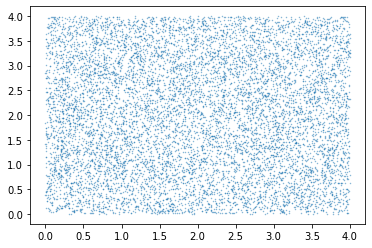

<IPython.core.display.Javascript object>

In [30]:
n_simulations = 10000
rho = np.vstack(
    (np.random.random(size=n_simulations) * 4, np.random.random(size=n_simulations) * 4)
).T
plt.scatter(rho[:, 0], rho[:, 1], alpha=0.6, s=0.2)

(array([ 992., 1017., 1027.,  941., 1022.,  966., 1029.,  995., 1018.,
         993.]),
 array([6.03082442e-05, 1.00048987e-01, 2.00037665e-01, 3.00026343e-01,
        4.00015022e-01, 5.00003700e-01, 5.99992378e-01, 6.99981057e-01,
        7.99969735e-01, 8.99958413e-01, 9.99947092e-01]),
 <BarContainer object of 10 artists>)

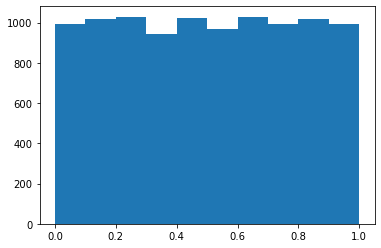

<IPython.core.display.Javascript object>

In [31]:
tendency_to_rate = np.random.random(size=n_simulations)
plt.hist(tendency_to_rate)

In [32]:
# output = np.empty((rho.shape[0], 5), dtype=np.float32)
with tqdm_joblib(tqdm(desc="Simulations", total=n_simulations)) as progress_bar:
    output = Parallel(n_jobs=16)(
        delayed(model)(rho[i, :]) for i in range(rho.shape[0])
    )

Simulations: 100%|██████████| 10000/10000 [03:47<00:00, 43.89it/s]


<IPython.core.display.Javascript object>

In [33]:
output = np.array(output)
output.shape

(10000, 5)

<IPython.core.display.Javascript object>

In [34]:
output[:10]

array([[107., 450., 117.,   2., 143.],
       [ 51.,   4.,  19., 140.,  64.],
       [ 67., 163., 122., 175.,  99.],
       [ 34., 314.,  16.,  11., 109.],
       [303.,  43.,  39.,   8., 273.],
       [124.,  92.,  78.,  41.,  44.],
       [324., 226., 143.,  58., 180.],
       [ 21.,  14.,  24.,  50.,  17.],
       [459.,   2.,   1.,   2., 314.],
       [ 45., 171., 197., 104.,  56.]])

<IPython.core.display.Javascript object>

In [35]:
# Make a combined array of all the simulation parameters
#theta = np.concatenate((rho, tendency_to_rate[:, None]), axis=1)
#theta.shape

<IPython.core.display.Javascript object>

In [36]:
# Convert everything into torch tensors to be fed into SNPE
output = torch.from_numpy(output).type(torch.FloatTensor)
#theta = torch.from_numpy(theta).type(torch.FloatTensor)
theta = torch.from_numpy(rho).type(torch.FloatTensor)

<IPython.core.display.Javascript object>

In [37]:
inference = SNPE(prior, device="cpu", show_progress_bars=True)

<IPython.core.display.Javascript object>

In [38]:
density_estimator = inference.append_simulations(theta, output).train(training_batch_size=100, 
                                                                      show_train_summary=True)

Neural network successfully converged after 194 epochs.

        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 194
        Best validation performance: -0.1894
        -------------------------
        


<IPython.core.display.Javascript object>

In [39]:
posterior = inference.build_posterior(density_estimator)

<IPython.core.display.Javascript object>

In [65]:
data1 = model(np.array([3.5, 1.9]))
data2 = model(np.array([0.7, 2.2]))
data3 = model(np.array([1.1, 0.5]))
print(data1)
print(data2)
print(data3)

[147.  94. 115. 220. 242.]
[103. 186.   3.   0. 138.]
[354.   8.   0. 409.  61.]


<IPython.core.display.Javascript object>

In [80]:
data1 * 20

array([2940., 1880., 2300., 4400., 4840.])

<IPython.core.display.Javascript object>

In [83]:
# samples = posterior.sample((10000,), x=torch.tensor([50.0, 30.0, 20.0, 100.0, 200.0]))
samples1 = posterior.sample(
    (10000,), x=torch.tensor(data1).type(torch.FloatTensor) / 20.0
)
samples2 = posterior.sample((10000,), x=torch.tensor(data2).type(torch.FloatTensor))
samples3 = posterior.sample((10000,), x=torch.tensor(data3).type(torch.FloatTensor))

<IPython.core.display.Javascript object>

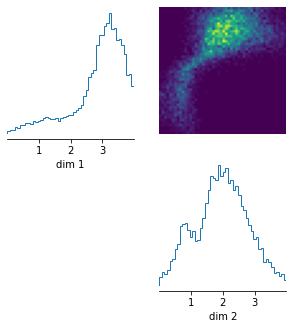

<IPython.core.display.Javascript object>

In [84]:
_ = utils.pairplot(samples1, fig_size=(5, 5))

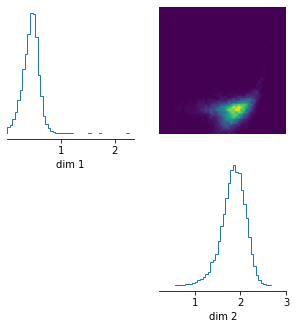

<IPython.core.display.Javascript object>

In [68]:
_ = utils.pairplot(samples2, fig_size=(5, 5))

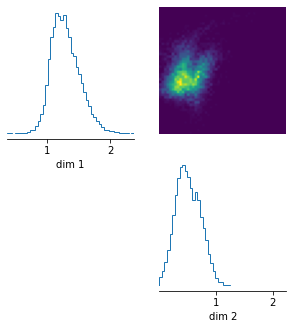

<IPython.core.display.Javascript object>

In [69]:
_ = utils.pairplot(samples3, fig_size=(5, 5))

# Multiple rounds of inference

In [60]:
# num_dim = 2
prior = utils.BoxUniform(
    low=torch.tensor([0.0, 0.0]).type(torch.FloatTensor),
    high=torch.tensor([4.0, 4.0]).type(torch.FloatTensor),
)

<IPython.core.display.Javascript object>

In [61]:
posteriors = []
proposal = prior
# x_o = torch.tensor([50.0, 30.0, 20.0, 100.0, 200.0]).type(torch.FloatTensor)
x_o = torch.tensor(data3).type(torch.FloatTensor)
inference = SNPE(prior=prior)

for _ in range(3):
    n_simulations = 2000
    theta = proposal.sample((n_simulations,)).numpy()
    # rho = theta[:, :2]
    # tendency_to_rate = theta[:, 2]
    output = Parallel(n_jobs=16)(
        delayed(model)(theta[i, :]) for i in range(theta.shape[0])
    )
    output = torch.from_numpy(np.array(output)).type(torch.FloatTensor)
    theta = torch.from_numpy(theta).type(torch.FloatTensor)

    # In `SNLE` and `SNRE`, you should not pass the `proposal` to `.append_simulations()`
    multi_density_estimator = inference.append_simulations(
        theta, output, proposal=proposal
    ).train(training_batch_size=100, show_train_summary=True)
    multi_posterior = inference.build_posterior(multi_density_estimator)
    posteriors.append(multi_posterior)
    proposal = multi_posterior.set_default_x(x_o)

Neural network successfully converged after 86 epochs.

        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 86
        Best validation performance: -0.9116
        -------------------------
        



Using SNPE-C with atomic loss
Neural network successfully converged after 93 epochs.

        -------------------------
        ||||| ROUND 2 STATS |||||:
        -------------------------
        Epochs trained: 93
        Best validation performance: -0.7018
        -------------------------
        



Using SNPE-C with atomic loss
Neural network successfully converged after 27 epochs.

        -------------------------
        ||||| ROUND 3 STATS |||||:
        -------------------------
        Epochs trained: 27
        Best validation performance: -0.8834
        -------------------------
        


<IPython.core.display.Javascript object>

In [52]:
multi_samples = posteriors[-1].sample((2000,), x=x_o)

<IPython.core.display.Javascript object>

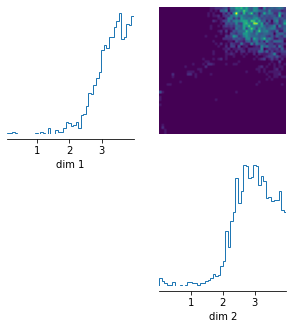

<IPython.core.display.Javascript object>

In [53]:
_ = utils.pairplot(multi_samples, fig_size=(5, 5))

In [54]:
x_o

tensor([ 35., 178., 159., 206., 115.])

<IPython.core.display.Javascript object>

In [57]:
multi_samples = posteriors[-1].sample((2000,), x=x_o)

<IPython.core.display.Javascript object>

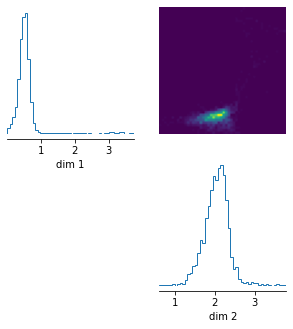

<IPython.core.display.Javascript object>

In [58]:
_ = utils.pairplot(multi_samples, fig_size=(5, 5))

In [59]:
x_o

tensor([14., 76.,  2.,  0., 31.])

<IPython.core.display.Javascript object>

In [62]:
multi_samples = posteriors[-1].sample((2000,), x=x_o)

<IPython.core.display.Javascript object>

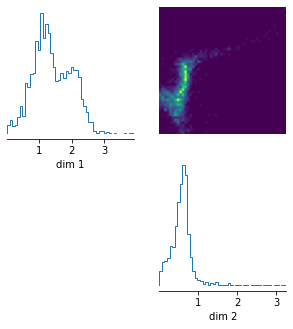

<IPython.core.display.Javascript object>

In [63]:
_ = utils.pairplot(multi_samples, fig_size=(5, 5))

In [64]:
x_o

tensor([ 36.,  12.,   0., 124.,   7.])

<IPython.core.display.Javascript object>

In [95]:
model(np.array([2.0, 1.5]))

array([262.,   1.,   1.,   5., 404.])

<IPython.core.display.Javascript object>

# Future steps

1. Correlate the obtained $\rho$ with price and brand (for now - may add other features like text embeddings in the future)
2. Incorporate time series information (through a CNN if $\rho$ equal over time, through RNN if we assume $\rho$ to vary)
3. Can add weights as parameters in the GM to tease apart competing explanations (e.g conformity, BM vs motivation), can also add other product features and infer weights directly in the model (vs separate regression)

In [35]:
np.random.dirichlet

<function RandomState.dirichlet>

<IPython.core.display.Javascript object>